# Ecuaciones de Cinetica Puntual

## Ecuaciones de cinética de un reactor nuclear

Las ecuaciones de cinética puntual del núcleo de un reactor a un grupo de energía y a un grupo de precursores sin fuente de neutrones son:

$$\begin{eqnarray}
\frac{dn(t)}{dt}&=&\frac{\rho(t)-\beta}{\Lambda}n(t)+\lambda c(t)\\
\frac{dc(t)}{dt}&=&\frac{\beta}{\Lambda}n(t)-\lambda c(t)
\end{eqnarray}$$

con $n$ el flujo neutrónico normalizado (en realidad es población de neutrones, pero bajo ciertas condiciones se puede considerar proporcional al flujo netrónico o potencia nuclear), $c$ la concentración de precursores, y $\rho$ la reactividad introducida en el mismo por las barras de control. Los parámetros del sistema son: $\Lambda = 1,76e^{-4} s$ (tiempo de reproducción de los neutrones rápidos), $\lambda = 0,076 1/s$ y $\beta = 765$pcm (fracción de neutrones que son absorbidos por precursores).

In [1]:
import sympy as sp
sp.init_printing()
n, r, b, L, l, c = sp.symbols('n, rho, beta, Lambda, lambda, c')

Definimos las ecuaciones de estados, es decir, las derivadas de las varables de estados en función de los estados y las entradas.

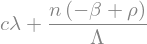

In [2]:
dn=(r-b)/L*n+l*c
dn

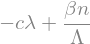

In [3]:
dc=b/L*n-l*c
dc

Ahora le decimos a sympy que lo represente en forma matricial:

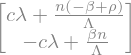

In [4]:
s=sp.Matrix([dn,dc]) #las ecuaciones de estados
s

In [5]:
x=sp.Matrix([n,c]) #definimos el vector de estados
x

In [6]:
u=sp.Matrix([r]) #definimos el vector de entradas
u

## Linealización utilizando sympy

Recordando la función Jacobiano, podemos valernos de esta para linearizar el sistema

In [7]:
A=s.jacobian(x) # la matriz A del espacio de estados
B=s.jacobian(u) #la matriz B del espacio de estados

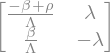

In [8]:
A

In [9]:
B

Finalmente evaluamos las matrices A y B en los vlaores de los parametros que tenemos dados.

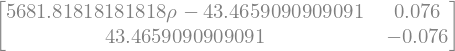

In [10]:
A.subs([(l, 0.076), (b,765e-5),(L,1.76e-4)])

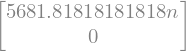

In [11]:
B.subs([(l, 0.076), (B,765e-5),(L,1.76e-4)])

Para obtener el punto de equilibrio, suponemos que trabajaremos alrededor de $n=1$, y lo que se hace es igualar a cero las ecuaciones de la derivada.

In [12]:
s2=s.subs([(l, 0.076), (b,765e-5),(L,1.76e-4),(n,1)])
sol0=sp.solve(s2,(c,r))

In [13]:
c0=sol0[c]
r0=sol0[r]

In [14]:
An=A.subs([(l, 0.076), (b,765e-5),(L,1.76e-4),(n,1),(r,r0),(c,c0)])

In [15]:
Bn=B.subs([(l, 0.076), (b,765e-5),(L,1.76e-4),(n,1),(r,r0),(c,c0)])

## Simulación numérica

In [16]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib qt5

In [17]:
l=0.076
b=765e-5
L=1.76e-4
n0=1


In [18]:
def dx(t,x):
    n=x[0]
    c=x[1]
    r= r0 if t<0 else r0 -50e-5 #1000pcm para poner un valor
    dn=(r-b)/L*n+l*c
    dc=b/L*n-l*c
    return ([dn,dc])

In [19]:
sol = solve_ivp(dx, (0,7), (n0,c0), method='BDF')
t= sol.t
n=sol.y[0]
c=sol.y[1]


La simulación dinámica del sistema lineal la podemos hacer usando directamente el módulo de control.

In [20]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

In [21]:
Cn=np.eye(2)
Dn=np.zeros((2,1))

In [22]:
sys = ctrl.ss(An,Bn,Cn,Dn)
t2,y2 = ctrl.step_response(sys)

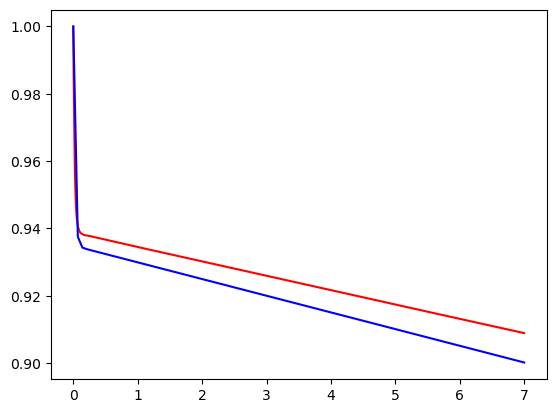

In [23]:
plt.figure()
plt.plot(t,n,'r',t2,y2[0,:]*-50e-5+n0,'b')
plt.gcf()

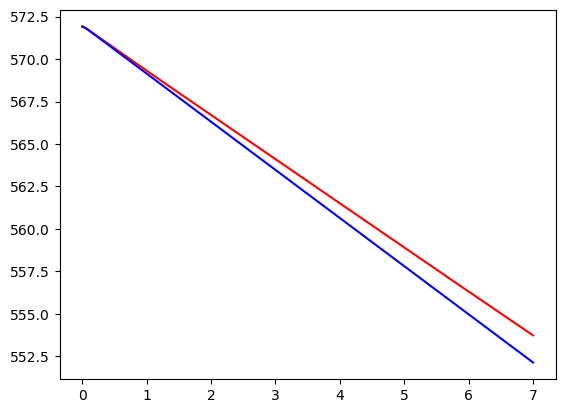

In [24]:
plt.figure()
plt.plot(t,sol.y[1],'r',t2,y2[1,:]*-50e-5+c0,'b')
plt.gcf()

Vemos que el sistema linearizado es una muy buena aproximación del no lineal. Esto es por que la perturbación de 10pcm es suficientemente chica y el sistema no se aleja demasiado del punto del cual linealizamos.

## Probemos aumentado un poco más la reactividad de entrada a 200 pcm

In [25]:
def dx(t,x):
    n=x[0]
    c=x[1]
    r= r0 if t<0 else r0 -200e-5 #1000pcm para poner un valor
    dn=(r-b)/L*n+l*c
    dc=b/L*n-l*c
    return ([dn,dc])

In [26]:
sol = solve_ivp(dx, (0,7), (n0,c0), method='BDF')
t= sol.t
n=sol.y[0]
c=sol.y[1]

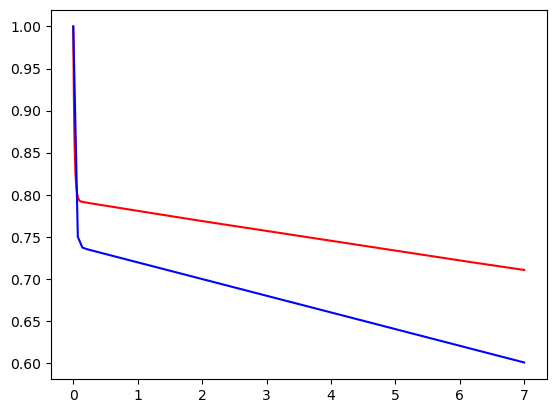

In [27]:
plt.figure()
plt.plot(t,n,'r',t2,y2[0,:]*-200e-5+n0,'b')
plt.gcf()

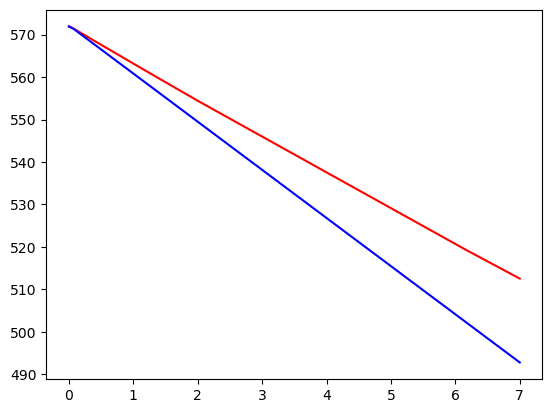

In [28]:
plt.figure()
plt.plot(t,sol.y[1],'r',t2,y2[1,:]*-200e-5+c0,'b')
plt.gcf()

Vemos como ahora la aproximación es bastante peor a la que teníamos cuando lo perturbabamos con 50 pcms.